In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense,Input, Lambda
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence
from keras.models import Model
from keras.utils import plot_model
from keras import optimizers
from keras.callbacks import EarlyStopping

from IPython.display import SVG

from keras import backend as K

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


## Load BRCA labelled data and Full TCGA data

In [2]:
X_brca = pd.read_csv("TCGA817-FULL_SET.csv")

In [3]:
X_tcga_full = pd.read_csv("/home/nanni/Data/TCGA/Xena/tcga.tsv", sep="\t")

/home/cristovao/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
X_tcga_full.drop(['sample', 'tumor_type', 'project', 'tissue_site', 'participant', 'cancer_code', 'sample_type'], axis="columns", inplace=True)

## Find common genes

In [5]:
tcga_indices = X_tcga_full.columns.tolist()
brca_indices = X_brca.columns.tolist()[2:]

common_indices = list(set(tcga_indices).intersection(brca_indices))

#Select only most common
X_tcga_full = X_tcga_full[common_indices]

Y = X_brca["Ciriello_subtype"]
X_brca = X_brca[common_indices]

### Select most variant BRCA genes on both

In [6]:
variance = X_brca.var(axis=0).sort_values(ascending=False)[:5000]
X_brca_variant = X_brca[variance.index.values]
X_brca_variant = pd.concat([Y, X_brca_variant], axis=1)

# Now get only the most variant of brca on tcga full
tcga_indices = X_tcga_full.columns.tolist()
brca_indices = X_brca_variant.columns.tolist()[1:]

common_indices = list(set(tcga_indices).intersection(brca_indices))

x_tcga_full_variant = X_tcga_full[common_indices]
x_tcga_full_variant

,IFI27,VCAN,COL9A2,CCR10,GRIA1,IDO1,CHD5,GPR63,NBPF22P,PLCD4,...,TRERF1,GIMAP1,RYR3,DNAJC12,TTC39A,PHLDA1,CCNJL,SATB1,ZNF285,HOXB7
0,10.9151,10.9691,6.2950,5.5666,0.9937,7.0665,3.1588,5.1005,3.1588,6.1045,...,8.8405,5.6315,4.1581,5.7210,9.7400,11.6982,7.6740,8.8057,5.8205,7.6810
1,14.6110,12.8886,6.2139,4.0320,0.3497,8.0370,1.6755,4.5873,1.2457,6.3365,...,8.3681,5.5659,4.5199,6.1596,6.1373,11.5996,4.7432,9.1264,3.5138,9.7161
2,11.7550,10.1643,4.8120,3.2773,0.0000,3.3736,1.8780,3.6674,0.0000,5.2141,...,10.0006,4.6485,3.0631,3.5487,8.1664,11.3543,3.7414,8.6022,1.7403,8.7485
3,10.3729,10.6354,8.8294,3.7872,1.6481,5.9418,5.1926,3.7495,2.2966,5.7738,...,8.9588,4.8273,3.5449,5.3393,9.3612,10.3487,5.0450,8.6772,1.0476,9.4103
4,11.4593,11.8752,9.4937,7.2314,2.4886,8.7731,8.9462,6.3263,2.7803,6.9179,...,9.7314,5.6455,3.8911,11.4437,10.9245,11.2342,7.2514,10.0019,1.6306,8.6046
5,9.9942,12.8323,7.4765,3.3298,0.8471,3.0801,0.3406,4.0397,0.0000,5.7333,...,8.1529,3.7848,2.9862,5.0190,5.1654,10.8680,4.3905,8.8383,4.5301,8.3589
6,11.6833,13.9735,8.6578,3.9602,3.4781,5.5070,7.3854,6.0045,1.0289,6.3137,...,10.0411,3.8078,5.0440,3.7251,9.5864,12.6470,6.9052,8.5657,1.4960,8.6192
7,7.1617,12.9992,6.9946,2.5409,1.3255,6.5558,3.5661,7.1738,0.3798,6.7977,...,9.2248,3.5661,4.0055,6.2423,9.5848,12.5571,6.8775,7.2153,3.9504,6.8248
8,11.6983,9.2230,9.7023,3.7123,0.8260,8.3740,3.4315,5.6644,0.0000,5.3182,...,10.9143,4.7831,2.9444,1.6139,8.5715,9.8290,5.7973,9.5549,1.4871,8.6243
9,10.1561,10.3730,5.9047,2.9018,2.6273,5.0604,3.3310,3.5856,0.0000,5.3394,...,8.5761,5.0321,5.4070,2.9018,10.2633,12.2713,9.1532,9.9344,5.9047,2.7711


In [7]:
### Preprocess TCGA common indexes

In [8]:
scaler_tcga = MinMaxScaler()
scaler_tcga.fit(x_tcga_full_variant)
x_tcga_full_variant_scaled = scaler_tcga.transform(x_tcga_full_variant)

In [9]:
X_brca_train, X_brca_test = train_test_split(X_brca_variant, stratify=Y, test_size=0.2)

Y_train = X_brca_train["Ciriello_subtype"]
Y_test = X_brca_test["Ciriello_subtype"]

X_brca_variant.drop(['Ciriello_subtype'], axis="columns", inplace=True)
X_brca_train.drop(['Ciriello_subtype'], axis="columns", inplace=True)
X_brca_test.drop(['Ciriello_subtype'], axis="columns", inplace=True)

scaler_brca = MinMaxScaler()
scaler_brca.fit(X_brca_train)
X_brca_train_scaled = scaler_brca.transform(X_brca_train)
X_brca_test_scaled = scaler_brca.transform(X_brca_test)

/home/cristovao/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Initialize variables and hyperparameters

In [10]:
original_dim = x_tcga_full_variant_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = 100
latent_dim = 100

batch_size = 100
epochs = 150 # 50 was too much, it was stabilized
learning_rate = 0.001

## Define functions

In [11]:
def sampling(args):
    
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    # E[log P(X|z)]
    reconstruction_loss = original_dim * binary_crossentropy(y_true, y_pred) # because it returns the mean cross-entropy
    # reconstruction_loss = mse(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl_loss = -0.5 * K.sum(1. + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=1)

    return K.mean(reconstruction_loss + kl_loss)

## Build Encoder

In [12]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5000)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          500100      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

## Build Decoder 

In [13]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_hidden = Dense(intermediate_dim, activation='relu', name='decoder_hidden')(latent_inputs)
outputs = Dense(input_shape[0], activation='sigmoid', name='decoder_output')(decoder_hidden)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 100)               0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 100)               10100     
_________________________________________________________________
decoder_output (Dense)       (None, 5000)              505000    
Total params: 515,100
Trainable params: 515,100
Non-trainable params: 0
_________________________________________________________________


## Build Variational Autoencoder

In [14]:
outputs = decoder(encoder(inputs)[2]) # fetches the z layer, the sampled one
vae = Model(inputs, outputs, name='vae')

adam = optimizers.Adam(lr=learning_rate)

vae.compile(optimizer=adam, loss=vae_loss)
vae.summary()

# plot_model(vae, to_file='vae_mlp_autoencoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 5000)              0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 520300    
_________________________________________________________________
decoder (Model)              (None, 5000)              515100    
Total params: 1,035,400
Trainable params: 1,035,400
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [16]:
x_tcga_full_scaled_train, x_tcga_full_scaled_val = train_test_split(x_tcga_full_variant_scaled, test_size=0.1)

In [17]:
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=10, inter_op_parallelism_threads=10)))

fit_hist = vae.fit(x_tcga_full_scaled_train, x_tcga_full_scaled_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=4)],
        validation_data=(x_tcga_full_scaled_val, x_tcga_full_scaled_val))

Train on 10435 samples, validate on 1160 samples
Epoch 1/150
10435/10435 [==============================] - 9s 861us/step - loss: 3118.8105 - val_loss: 3061.8832
Epoch 2/150
10435/10435 [==============================] - 7s 669us/step - loss: 3062.4925 - val_loss: 3060.1538
Epoch 3/150
10435/10435 [==============================] - 7s 664us/step - loss: 3061.2563 - val_loss: 3058.6187
Epoch 4/150
10435/10435 [==============================] - 7s 693us/step - loss: 3060.7770 - val_loss: 3059.0096
Epoch 5/150
10435/10435 [==============================] - 7s 674us/step - loss: 3060.3843 - val_loss: 3058.8857
Epoch 6/150
10435/10435 [==============================] - 8s 743us/step - loss: 3060.0815 - val_loss: 3057.5977
Epoch 7/150
10435/10435 [==============================] - 7s 689us/step - loss: 3060.0464 - val_loss: 3058.1914
Epoch 8/150
10435/10435 [==============================] - 7s 674us/step - loss: 3059.8586 - val_loss: 3057.6421
Epoch 9/150
10435/10435 [======================

## Visualize training performance

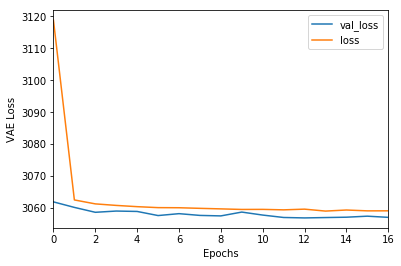

In [18]:
history_df = pd.DataFrame(fit_hist.history)
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()

## Train Logistic Regression Classifier

In [19]:
encoded_train_data = encoder.predict(X_brca_train_scaled)
encoded_train_data = pd.DataFrame(encoded_train_data[0])

encoded_test_data = encoder.predict(X_brca_test_scaled)
encoded_test_data = pd.DataFrame(encoded_test_data[0])

In [20]:
clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(encoded_train_data, Y_train)

In [21]:
clf.score(encoded_test_data, Y_test)

0.5060975609756098